## Run the below import cell first

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sqlite3
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

# The four cells below this one will create the same type of DF used in the tutorial. Next step, killing my CPU or GPU

**NOTE**: I think eventually I'd like to add other information in here, such as the sector IDs and such for the symbols.

In [63]:
# One

conn = sqlite3.connect('stockPrediction.db')

query = "SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM price_history l INNER JOIN stock r ON r.stock_id = l.stock_id;"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

# columns = pd.MultiIndex.from_product([[i for i in symbols], ['open_price', 'high_price', 'low_price', 'close_price']], names=['symbol', 'type'])

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])

In [64]:
# cell to drop all rows w/ timestamps at weird times (not 00 seconds)
df = df.reset_index()
df['price_datetime'] = pd.to_datetime(df['price_datetime'])

df = df.loc[df['price_datetime'].dt.second == 0]
df = df.loc[(df['price_datetime'].dt.minute == 0) | (df['price_datetime'].dt.minute == 15) | (df['price_datetime'].dt.minute == 30) | (df['price_datetime'].dt.minute == 45)]
df = df.set_index(['stock_symbol', 'price_datetime'])

In [ ]:
df

In [65]:
# Two

# remove stocks w/ less than 1000 data points
s = df.groupby(level=0).size()
s = s.where(s > 1000).dropna()
dfs = s.to_frame()
dfs = dfs.reset_index()
df = df.reset_index()
dfs

,stock_symbol,0
0,AACG,1513.0
1,AAGFF,1479.0
2,AAIC,1582.0
3,AAME,1513.0
4,AAU,1586.0
...,...,...
1090,ZNOG,1522.0
1091,ZOM,1534.0
1092,ZSAN,1534.0
1093,ZVO,1528.0


In [66]:
# Three
df = pd.merge(df, dfs, how='inner', left_on='stock_symbol', right_on='stock_symbol', left_index=True)
df = df.drop_duplicates()
# this line below added in on 5/14 22:37:
df = df.drop(columns=[0])
df

,stock_symbol,price_datetime,open_price,high_price,low_price,close_price,volume,dividends,stock_splits
150,BLPH,2021-02-11 09:30:00,8.300000,8.400000,8.200000,8.200000,8052.0,0.0,0
150,BLPH,2021-02-11 09:45:00,8.232900,8.232900,8.060000,8.060000,1669.0,0.0,0
150,BLPH,2021-02-11 10:00:00,8.130000,8.130000,8.130000,8.130000,232.0,0.0,0
150,BLPH,2021-02-11 10:30:00,8.210000,8.270000,8.120000,8.199400,2190.0,0.0,0
150,BLPH,2021-02-11 10:45:00,8.260000,8.260000,8.140000,8.140000,505.0,0.0,0
...,...,...,...,...,...,...,...,...,...
421,GME,2021-05-10 14:45:00,145.356003,145.356003,143.360001,144.059998,155323.0,0.0,0
421,GME,2021-05-10 15:00:00,143.860001,145.470001,143.827103,144.535004,137988.0,0.0,0
421,GME,2021-05-10 15:15:00,144.520004,144.990005,143.809998,144.020004,134012.0,0.0,0
421,GME,2021-05-10 15:30:00,144.071793,144.539993,143.250000,143.257004,178830.0,0.0,0


In [10]:
# Five?
# Imputing to remove NaN's
impute_columns = []
imputer = KNNImputer(n_neighbors=2, weights='uniform')
imputed_data = imputer.fit_transform(df[['open_price', 'high_price', 'low_price', 'close_price', 'volume', 'dividends']])
clean_data = pd.DataFrame(imputed_data, columns=['open_price', 'high_price', 'low_price', 'close_price', 'volume', 'dividends'])
df = pd.merge(df, clean_data)

In [21]:
df = df.drop_duplicates()
df

,stock_symbol,price_datetime,open_price,high_price,low_price,close_price,volume,dividends,stock_splits
150,BLPH,2021-02-11 09:30:00,8.300000,8.400000,8.200000,8.200000,8052.0,0.0,0
150,BLPH,2021-02-11 09:45:00,8.232900,8.232900,8.060000,8.060000,1669.0,0.0,0
150,BLPH,2021-02-11 10:00:00,8.130000,8.130000,8.130000,8.130000,232.0,0.0,0
150,BLPH,2021-02-11 10:30:00,8.210000,8.270000,8.120000,8.199400,2190.0,0.0,0
150,BLPH,2021-02-11 10:45:00,8.260000,8.260000,8.140000,8.140000,505.0,0.0,0
...,...,...,...,...,...,...,...,...,...
421,GME,2021-05-10 14:45:00,145.356003,145.356003,143.360001,144.059998,155323.0,0.0,0
421,GME,2021-05-10 15:00:00,143.860001,145.470001,143.827103,144.535004,137988.0,0.0,0
421,GME,2021-05-10 15:15:00,144.520004,144.990005,143.809998,144.020004,134012.0,0.0,0
421,GME,2021-05-10 15:30:00,144.071793,144.539993,143.250000,143.257004,178830.0,0.0,0


In [67]:
# Four

# df = df.drop_duplicates(subset=['price_datetime'])
df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])
df

open_price                                             \
stock_symbol              AACG     AAGFF   AAIC    AAME       AAU    ABEO   
price_datetime                                                              
2021-02-11 09:30:00      6.020  1.025000  3.690  5.6100  0.963900  3.4550   
2021-02-11 09:45:00      6.230  0.998050  3.710  5.4500  0.918901  3.3796   
2021-02-11 10:00:00      6.035  0.987100  3.740  5.4999  0.936800  3.3070   
2021-02-11 10:15:00      5.970  0.976500  3.740  5.4100  0.939900  3.2886   
2021-02-11 10:30:00      5.980  0.990100  3.730  5.4466  0.947001  3.3300   
...                        ...       ...    ...     ...       ...     ...   
2021-05-10 14:45:00      2.890       NaN  4.065  3.9700  0.542500  1.3801   
2021-05-10 15:00:00      2.860       NaN  4.055  3.9800  0.540000  1.3900   
2021-05-10 15:15:00      2.850  0.558332  4.060  4.0000  0.540041  1.3850   
2021-05-10 15:30:00      2.890  0.559499  4.045  4.0000  0.540900  1.3850   
2021-05-10 15:45:00      2.891  0.553600  4.045  4.0300  0.540900  1.3850   

                                                   ... stock_splits            \
stock_symbol          ABEPF   ABEV    ABIO   ABML  ...         YTRA  YVR ZCMD   
price_datetime                                     ...                          
2021-02-11 09:30:00  0.5800  2.820  5.2885  3.720  ...          NaN  NaN  NaN   
2021-02-11 09:45:00  0.5947  2.855  5.4800  3.690  ...          NaN  NaN  NaN   
2021-02-11 10:00:00  0.5700  2.830  5.4200  3.670  ...          NaN  NaN  NaN   
2021-02-11 10:15:00  0.5999  2.835  5.3500  3.620  ...          NaN  NaN  NaN   
2021-02-11 10:30:00  0.5497  2.830  5.3900  3.610  ...          NaN  NaN  NaN   
...                     ...    ...     ...    ...  ...          ...  ...  ...   
2021-05-10 14:45:00     NaN  3.215  3.1080  1.630  ...            0    0    0   
2021-05-10 15:00:00     NaN  3.200  3.1000  1.595  ...            0    0    0   
2021-05-10 15:15:00  0.1215  3.200  3.1100  1.575  ...            0    0    0   
2021-05-10 15:30:00  0.1214  3.210  3.0950  1.590  ...            0    0    0   
2021-05-10 15:45:00  0.1194  3.215  3.0850  1.580  ...            0    0    0   

                                                        
stock_symbol        ZIOP ZKIN ZNOG  ZOM ZSAN  ZVO ZYNE  
price_datetime                                          
2021-02-11 09:30:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2021-02-11 09:45:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2021-02-11 10:00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2021-02-11 10:15:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2021-02-11 10:30:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...                  ...  ...  ...  ...  ...  ...  ...  
2021-05-10 14:45:00    0    0    0    0    0    0    0  
2021-05-10 15:00:00    0    0  NaN    0    0    0    0  
2021-05-10 15:15:00    0    0    0    0    0  NaN    0  
2021-05-10 15:30:00    0    0    0    0    0    0    0  
2021-05-10 15:45:00    0    0    0    0    0    0    0  

[1586 rows x 7665 columns]

## ** TO DO **
Need to write something that eliminates all of the NaN values in the dataframe, or gets rid of the symbol entirely. The Imputer doesn't seem to be working the way it should be.

In [28]:
df[['close_price']]

close_price                                            \
stock_symbol               AACG     AAGFF    AAIC  AAME       AAU    ABEO   
price_datetime                                                              
2021-02-11 09:30:00      6.2300  0.989800  3.7270  5.40  0.920000  3.3700   
2021-02-11 09:45:00      6.1000  0.967000  3.7400  5.47  0.936200  3.3043   
2021-02-11 10:00:00      5.9783  0.970000  3.7400  5.42  0.932201  3.2800   
2021-02-11 10:15:00      5.9971  0.981400  3.7390  5.45  0.948600  3.3281   
2021-02-11 10:30:00      5.9125  0.990100  3.7250  5.41  0.999800  3.3106   
...                         ...       ...     ...   ...       ...     ...   
2021-05-10 14:45:00      2.8750       NaN  4.0525  3.98  0.540000  1.3850   
2021-05-10 15:00:00      2.8500       NaN  4.0600  4.00  0.540799  1.3850   
2021-05-10 15:15:00      2.8500  0.558332  4.0450  4.04  0.540800  1.3842   
2021-05-10 15:30:00      2.9000  0.551000  4.0450  4.00  0.540900  1.3900   
2021-05-10 15:45:00      2.8800  0.553600  4.0600  3.98  0.540000  1.3400   

                                                     ...                \
stock_symbol          ABEPF    ABEV    ABIO    ABML  ...  YTRA     YVR   
price_datetime                                       ...                 
2021-02-11 09:30:00  0.5948  2.8600  5.4354  3.6865  ...   NaN     NaN   
2021-02-11 09:45:00  0.5627  2.8350  5.4300  3.6600  ...   NaN     NaN   
2021-02-11 10:00:00  0.5901  2.8400  5.3500  3.6100  ...   NaN     NaN   
2021-02-11 10:15:00  0.5334  2.8311  5.3700  3.6200  ...   NaN     NaN   
2021-02-11 10:30:00  0.5600  2.8300  5.4111  3.6145  ...   NaN     NaN   
...                     ...     ...     ...     ...  ...   ...     ...   
2021-05-10 14:45:00     NaN  3.2050  3.0910  1.6000  ...  1.94  2.0600   
2021-05-10 15:00:00     NaN  3.2000  3.1000  1.5700  ...  1.94  2.0399   
2021-05-10 15:15:00  0.1215  3.2098  3.1000  1.5900  ...  1.94  2.0400   
2021-05-10 15:30:00  0.1213  3.2150  3.0900  1.5700  ...  1.95  2.0400   
2021-05-10 15:45:00  0.1214  3.2000  3.0600  1.5800  ...  1.90  2.0100   

                                                                              \
stock_symbol           ZCMD  ZIOP    ZKIN    ZNOG       ZOM      ZSAN    ZVO   
price_datetime                                                                 
2021-02-11 09:30:00     NaN   NaN     NaN     NaN       NaN       NaN    NaN   
2021-02-11 09:45:00     NaN   NaN     NaN     NaN       NaN       NaN    NaN   
2021-02-11 10:00:00     NaN   NaN     NaN     NaN       NaN       NaN    NaN   
2021-02-11 10:15:00     NaN   NaN     NaN     NaN       NaN       NaN    NaN   
2021-02-11 10:30:00     NaN   NaN     NaN     NaN       NaN       NaN    NaN   
...                     ...   ...     ...     ...       ...       ...    ...   
2021-05-10 14:45:00  1.7401  3.03  5.0200  0.6200  0.783701  0.810400  3.410   
2021-05-10 15:00:00  1.7417  3.04  5.0124     NaN  0.791800  0.813300  3.395   
2021-05-10 15:15:00  1.7400  3.03  5.0000  0.6200  0.789200  0.811900    NaN   
2021-05-10 15:30:00  1.7550  3.02  4.9600  0.6298  0.780900  0.799799  3.410   
2021-05-10 15:45:00  1.7450  2.99  4.9700  0.6298  0.775300  0.795200  3.400   

                           
stock_symbol         ZYNE  
price_datetime             
2021-02-11 09:30:00   NaN  
2021-02-11 09:45:00   NaN  
2021-02-11 10:00:00   NaN  
2021-02-11 10:15:00   NaN  
2021-02-11 10:30:00   NaN  
...                   ...  
2021-05-10 14:45:00  4.28  
2021-05-10 15:00:00  4.28  
2021-05-10 15:15:00  4.28  
2021-05-10 15:30:00  4.24  
2021-05-10 15:45:00  4.18  

[1586 rows x 1095 columns]

In [7]:
df['close_price'].isnull().sum()

stock_symbol
AACG      73
AAGFF    107
AAIC       4
AAME      73
AAU        0
        ... 
ZNOG      64
ZOM       52
ZSAN      52
ZVO       58
ZYNE      52
Length: 1095, dtype: int64

In [29]:
df.reset_index()

price_datetime open_price                           \
stock_symbol                           AACG     AAGFF   AAIC    AAME   
0            2021-02-11 09:30:00      6.020  1.025000  3.690  5.6100   
1            2021-02-11 09:45:00      6.230  0.998050  3.710  5.4500   
2            2021-02-11 10:00:00      6.035  0.987100  3.740  5.4999   
3            2021-02-11 10:15:00      5.970  0.976500  3.740  5.4100   
4            2021-02-11 10:30:00      5.980  0.990100  3.730  5.4466   
...                          ...        ...       ...    ...     ...   
1581         2021-05-10 14:45:00      2.890       NaN  4.065  3.9700   
1582         2021-05-10 15:00:00      2.860       NaN  4.055  3.9800   
1583         2021-05-10 15:15:00      2.850  0.558332  4.060  4.0000   
1584         2021-05-10 15:30:00      2.890  0.559499  4.045  4.0000   
1585         2021-05-10 15:45:00      2.891  0.553600  4.045  4.0300   

                                                       ... stock_splits       \
stock_symbol       AAU    ABEO   ABEPF   ABEV    ABIO  ...         YTRA  YVR   
0             0.963900  3.4550  0.5800  2.820  5.2885  ...          NaN  NaN   
1             0.918901  3.3796  0.5947  2.855  5.4800  ...          NaN  NaN   
2             0.936800  3.3070  0.5700  2.830  5.4200  ...          NaN  NaN   
3             0.939900  3.2886  0.5999  2.835  5.3500  ...          NaN  NaN   
4             0.947001  3.3300  0.5497  2.830  5.3900  ...          NaN  NaN   
...                ...     ...     ...    ...     ...  ...          ...  ...   
1581          0.542500  1.3801     NaN  3.215  3.1080  ...            0    0   
1582          0.540000  1.3900     NaN  3.200  3.1000  ...            0    0   
1583          0.540041  1.3850  0.1215  3.200  3.1100  ...            0    0   
1584          0.540900  1.3850  0.1214  3.210  3.0950  ...            0    0   
1585          0.540900  1.3850  0.1194  3.215  3.0850  ...            0    0   

                                                      
stock_symbol ZCMD ZIOP ZKIN ZNOG  ZOM ZSAN  ZVO ZYNE  
0             NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1             NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2             NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3             NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4             NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...           ...  ...  ...  ...  ...  ...  ...  ...  
1581            0    0    0    0    0    0    0    0  
1582            0    0    0  NaN    0    0    0    0  
1583            0    0    0    0    0    0  NaN    0  
1584            0    0    0    0    0    0    0    0  
1585            0    0    0    0    0    0    0    0  

[1586 rows x 7666 columns]

In [38]:
df.close_price.columns

Index(['AACG', 'AAGFF', 'AAIC', 'AAME', 'AAU', 'ABEO', 'ABEPF', 'ABEV', 'ABIO',
       'ABML',
       ...
       'YTRA', 'YVR', 'ZCMD', 'ZIOP', 'ZKIN', 'ZNOG', 'ZOM', 'ZSAN', 'ZVO',
       'ZYNE'],
      dtype='object', name='stock_symbol', length=1095)

In [83]:
# condensing several of the above cells into this one
# One

conn = sqlite3.connect('stockPrediction.db')

query = "SELECT r.stock_symbol, l.price_datetime, l.open_price, l.high_price, l.low_price, l.close_price, l.volume, l.dividends, l.stock_splits FROM price_history l INNER JOIN stock r ON r.stock_id = l.stock_id;"

symbols = conn.execute('SELECT stock_symbol FROM stock')
symbols = symbols.fetchall()
symbols = [i[0] for i in symbols]
symbols = [i for i in symbols if i not in symbols]

# columns = pd.MultiIndex.from_product([[i for i in symbols], ['open_price', 'high_price', 'low_price', 'close_price']], names=['symbol', 'type'])

df = pd.read_sql(query, conn, index_col=['stock_symbol', 'price_datetime'])

# Two

# remove stocks w/ less than 1000 data points
s = df.groupby(level=0).size()
s = s.where(s > 1000).dropna()
dfs = s.to_frame()
dfs = dfs.reset_index()
df = df.reset_index()
# dfs

# Three
df = pd.merge(df, dfs, how='inner', left_on='stock_symbol', right_on='stock_symbol', left_index=True)
df = df.drop_duplicates()
# this line below added in on 5/14 22:37:
df = df.drop(columns=[0])

# Four

# df = df.drop_duplicates(subset=['price_datetime'])
df = df.set_index(['price_datetime', 'stock_symbol']).unstack(['stock_symbol'])
df

open_price                                           \
stock_symbol              AACG    AAGFF  AAIC    AAME       AAU    ABEO   
price_datetime                                                            
2021-02-11 09:30:00      6.020  1.02500  3.69  5.6100  0.963900  3.4550   
2021-02-11 09:45:00      6.230  0.99805  3.71  5.4500  0.918901  3.3796   
2021-02-11 10:00:00      6.035  0.98710  3.74  5.4999  0.936800  3.3070   
2021-02-11 10:15:00      5.970  0.97650  3.74  5.4100  0.939900  3.2886   
2021-02-11 10:30:00      5.980  0.99010  3.73  5.4466  0.947001  3.3300   
...                        ...      ...   ...     ...       ...     ...   
2021-05-10 15:58:23        NaN      NaN   NaN     NaN       NaN     NaN   
2021-05-10 15:58:53        NaN      NaN   NaN     NaN       NaN     NaN   
2021-05-10 15:59:19        NaN      NaN   NaN     NaN       NaN     NaN   
2021-05-10 15:59:49        NaN      NaN   NaN     NaN       NaN     NaN   
2021-05-10 15:59:56        NaN      NaN   NaN     NaN       NaN     NaN   

                                                  ... stock_splits            \
stock_symbol          ABEPF   ABEV    ABIO  ABML  ...         YTRA  YVR ZCMD   
price_datetime                                    ...                          
2021-02-11 09:30:00  0.5800  2.820  5.2885  3.72  ...          NaN  NaN  NaN   
2021-02-11 09:45:00  0.5947  2.855  5.4800  3.69  ...          NaN  NaN  NaN   
2021-02-11 10:00:00  0.5700  2.830  5.4200  3.67  ...          NaN  NaN  NaN   
2021-02-11 10:15:00  0.5999  2.835  5.3500  3.62  ...          NaN  NaN  NaN   
2021-02-11 10:30:00  0.5497  2.830  5.3900  3.61  ...          NaN  NaN  NaN   
...                     ...    ...     ...   ...  ...          ...  ...  ...   
2021-05-10 15:58:23     NaN    NaN     NaN   NaN  ...          NaN  NaN  NaN   
2021-05-10 15:58:53     NaN    NaN     NaN   NaN  ...          NaN  NaN  NaN   
2021-05-10 15:59:19     NaN    NaN     NaN   NaN  ...          NaN  NaN  NaN   
2021-05-10 15:59:49     NaN    NaN     NaN   NaN  ...          NaN  NaN  NaN   
2021-05-10 15:59:56     NaN    NaN     NaN   NaN  ...          NaN  NaN  NaN   

                                                        
stock_symbol        ZIOP ZKIN ZNOG  ZOM ZSAN  ZVO ZYNE  
price_datetime                                          
2021-02-11 09:30:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2021-02-11 09:45:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2021-02-11 10:00:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2021-02-11 10:15:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2021-02-11 10:30:00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...                  ...  ...  ...  ...  ...  ...  ...  
2021-05-10 15:58:23  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2021-05-10 15:58:53  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2021-05-10 15:59:19  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2021-05-10 15:59:49  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2021-05-10 15:59:56  NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[1818 rows x 7665 columns]

In [84]:
# attempting once again to impute
columns = df.close_price.columns
df = df.reset_index()
imputer = KNNImputer(n_neighbors=10, weights='uniform')
imputed_data = imputer.fit_transform(df[['close_price']])
clean_data = pd.DataFrame(imputed_data, columns=columns)
clean_data['price_datetime'] = df['price_datetime']
# df = pd.merge(df, clean_data, on='price_datetime')
clean_data

stock_symbol,AACG,AAGFF,AAIC,AAME,AAU,ABEO,ABEPF,ABEV,ABIO,ABML,...,YVR,ZCMD,ZIOP,ZKIN,ZNOG,ZOM,ZSAN,ZVO,ZYNE,price_datetime
0,6.23000,0.989800,3.72700,5.40000,0.920000,3.37000,0.594800,2.86000,5.43540,3.6865,...,2.20781,2.28128,4.76449,6.32860,0.855318,2.398570,1.697500,6.48241,5.75735,2021-02-11 09:30:00
1,6.10000,0.967000,3.74000,5.47000,0.936200,3.30430,0.562700,2.83500,5.43000,3.6600,...,2.20781,2.28128,4.76449,6.32860,0.855318,2.398570,1.697500,6.48241,5.75735,2021-02-11 09:45:00
2,5.97830,0.970000,3.74000,5.42000,0.932201,3.28000,0.590100,2.84000,5.35000,3.6100,...,2.20781,2.28128,4.76449,6.32860,0.855318,2.398570,1.697500,6.48241,5.75735,2021-02-11 10:00:00
3,5.99710,0.981400,3.73900,5.45000,0.948600,3.32810,0.533400,2.83110,5.37000,3.6200,...,2.20781,2.28128,4.76449,6.32860,0.855318,2.398570,1.697500,6.48241,5.75735,2021-02-11 10:15:00
4,5.91250,0.990100,3.72500,5.41000,0.999800,3.31060,0.560000,2.83000,5.41110,3.6145,...,2.20781,2.28128,4.76449,6.32860,0.855318,2.398570,1.697500,6.48241,5.75735,2021-02-11 10:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813,3.98401,0.780751,4.01251,4.69908,0.662170,1.79844,0.242174,3.02098,3.78061,2.2045,...,2.02655,1.93018,3.85800,6.41809,0.699952,1.368560,1.087680,4.66063,4.83458,2021-05-10 15:58:23
1814,2.92953,0.530266,4.04200,4.01731,0.548051,1.51118,0.125512,3.10088,3.17934,1.5135,...,2.10069,1.77127,3.01850,5.34000,0.677640,0.846860,0.822654,3.49689,4.23200,2021-05-10 15:58:53
1815,2.87087,0.598926,4.03100,3.90020,0.533225,1.54833,0.140456,2.98200,3.35301,1.4765,...,2.56572,1.78603,3.23399,5.47606,0.572645,0.884560,0.897630,3.63150,4.13759,2021-05-10 15:59:19
1816,3.43297,0.602720,4.07250,3.91450,0.539920,1.57385,0.141452,2.99024,3.33801,1.5360,...,2.50957,1.82950,3.22702,6.19434,0.630106,0.994430,0.931090,3.65420,4.33451,2021-05-10 15:59:49


In [41]:
df['close_price']

stock_symbol,AACG,AAGFF,AAIC,AAME,AAU,ABEO,ABEPF,ABEV,ABIO,ABML,...,YTRA,YVR,ZCMD,ZIOP,ZKIN,ZNOG,ZOM,ZSAN,ZVO,ZYNE
0,6.2300,0.989800,3.7270,5.40,0.920000,3.3700,0.5948,2.8600,5.4354,3.6865,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.1000,0.967000,3.7400,5.47,0.936200,3.3043,0.5627,2.8350,5.4300,3.6600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.9783,0.970000,3.7400,5.42,0.932201,3.2800,0.5901,2.8400,5.3500,3.6100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.9971,0.981400,3.7390,5.45,0.948600,3.3281,0.5334,2.8311,5.3700,3.6200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.9125,0.990100,3.7250,5.41,0.999800,3.3106,0.5600,2.8300,5.4111,3.6145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1581,2.8750,NaN,4.0525,3.98,0.540000,1.3850,NaN,3.2050,3.0910,1.6000,...,1.94,2.0600,1.7401,3.03,5.0200,0.6200,0.783701,0.810400,3.410,4.28
1582,2.8500,NaN,4.0600,4.00,0.540799,1.3850,NaN,3.2000,3.1000,1.5700,...,1.94,2.0399,1.7417,3.04,5.0124,NaN,0.791800,0.813300,3.395,4.28
1583,2.8500,0.558332,4.0450,4.04,0.540800,1.3842,0.1215,3.2098,3.1000,1.5900,...,1.94,2.0400,1.7400,3.03,5.0000,0.6200,0.789200,0.811900,NaN,4.28
1584,2.9000,0.551000,4.0450,4.00,0.540900,1.3900,0.1213,3.2150,3.0900,1.5700,...,1.95,2.0400,1.7550,3.02,4.9600,0.6298,0.780900,0.799799,3.410,4.24


In [55]:
df[['price_datetime', 'close_price']]

price_datetime close_price                          \
stock_symbol                            AACG     AAGFF    AAIC  AAME   
0            2021-02-11 09:30:00      6.2300  0.989800  3.7270  5.40   
1            2021-02-11 09:45:00      6.1000  0.967000  3.7400  5.47   
2            2021-02-11 10:00:00      5.9783  0.970000  3.7400  5.42   
3            2021-02-11 10:15:00      5.9971  0.981400  3.7390  5.45   
4            2021-02-11 10:30:00      5.9125  0.990100  3.7250  5.41   
...                          ...         ...       ...     ...   ...   
1581         2021-05-10 14:45:00      2.8750       NaN  4.0525  3.98   
1582         2021-05-10 15:00:00      2.8500       NaN  4.0600  4.00   
1583         2021-05-10 15:15:00      2.8500  0.558332  4.0450  4.04   
1584         2021-05-10 15:30:00      2.9000  0.551000  4.0450  4.00   
1585         2021-05-10 15:45:00      2.8800  0.553600  4.0600  3.98   

                                                        ...                \
stock_symbol       AAU    ABEO   ABEPF    ABEV    ABIO  ...  YTRA     YVR   
0             0.920000  3.3700  0.5948  2.8600  5.4354  ...   NaN     NaN   
1             0.936200  3.3043  0.5627  2.8350  5.4300  ...   NaN     NaN   
2             0.932201  3.2800  0.5901  2.8400  5.3500  ...   NaN     NaN   
3             0.948600  3.3281  0.5334  2.8311  5.3700  ...   NaN     NaN   
4             0.999800  3.3106  0.5600  2.8300  5.4111  ...   NaN     NaN   
...                ...     ...     ...     ...     ...  ...   ...     ...   
1581          0.540000  1.3850     NaN  3.2050  3.0910  ...  1.94  2.0600   
1582          0.540799  1.3850     NaN  3.2000  3.1000  ...  1.94  2.0399   
1583          0.540800  1.3842  0.1215  3.2098  3.1000  ...  1.94  2.0400   
1584          0.540900  1.3900  0.1213  3.2150  3.0900  ...  1.95  2.0400   
1585          0.540000  1.3400  0.1214  3.2000  3.0600  ...  1.90  2.0100   

                                                                             
stock_symbol    ZCMD  ZIOP    ZKIN    ZNOG       ZOM      ZSAN    ZVO  ZYNE  
0                NaN   NaN     NaN     NaN       NaN       NaN    NaN   NaN  
1                NaN   NaN     NaN     NaN       NaN       NaN    NaN   NaN  
2                NaN   NaN     NaN     NaN       NaN       NaN    NaN   NaN  
3                NaN   NaN     NaN     NaN       NaN       NaN    NaN   NaN  
4                NaN   NaN     NaN     NaN       NaN       NaN    NaN   NaN  
...              ...   ...     ...     ...       ...       ...    ...   ...  
1581          1.7401  3.03  5.0200  0.6200  0.783701  0.810400  3.410  4.28  
1582          1.7417  3.04  5.0124     NaN  0.791800  0.813300  3.395  4.28  
1583          1.7400  3.03  5.0000  0.6200  0.789200  0.811900    NaN  4.28  
1584          1.7550  3.02  4.9600  0.6298  0.780900  0.799799  3.410  4.24  
1585          1.7450  2.99  4.9700  0.6298  0.775300  0.795200  3.400  4.18  

[1586 rows x 1096 columns]

In [86]:
df2 = df['close_price']
df2

stock_symbol,AACG,AAGFF,AAIC,AAME,AAU,ABEO,ABEPF,ABEV,ABIO,ABML,...,YTRA,YVR,ZCMD,ZIOP,ZKIN,ZNOG,ZOM,ZSAN,ZVO,ZYNE
0,6.2300,0.9898,3.727,5.40,0.920000,3.3700,0.5948,2.8600,5.4354,3.6865,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.1000,0.9670,3.740,5.47,0.936200,3.3043,0.5627,2.8350,5.4300,3.6600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.9783,0.9700,3.740,5.42,0.932201,3.2800,0.5901,2.8400,5.3500,3.6100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5.9971,0.9814,3.739,5.45,0.948600,3.3281,0.5334,2.8311,5.3700,3.6200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.9125,0.9901,3.725,5.41,0.999800,3.3106,0.5600,2.8300,5.4111,3.6145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
df2['price_datetime'] = df['price_datetime']
df2

<ipython-input-87-4e0a425849a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['price_datetime'] = df['price_datetime']


stock_symbol,AACG,AAGFF,AAIC,AAME,AAU,ABEO,ABEPF,ABEV,ABIO,ABML,...,YVR,ZCMD,ZIOP,ZKIN,ZNOG,ZOM,ZSAN,ZVO,ZYNE,price_datetime
0,6.2300,0.9898,3.727,5.40,0.920000,3.3700,0.5948,2.8600,5.4354,3.6865,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-11 09:30:00
1,6.1000,0.9670,3.740,5.47,0.936200,3.3043,0.5627,2.8350,5.4300,3.6600,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-11 09:45:00
2,5.9783,0.9700,3.740,5.42,0.932201,3.2800,0.5901,2.8400,5.3500,3.6100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-11 10:00:00
3,5.9971,0.9814,3.739,5.45,0.948600,3.3281,0.5334,2.8311,5.3700,3.6200,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-11 10:15:00
4,5.9125,0.9901,3.725,5.41,0.999800,3.3106,0.5600,2.8300,5.4111,3.6145,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-02-11 10:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-10 15:58:23
1814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-10 15:58:53
1815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-10 15:59:19
1816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-05-10 15:59:49


In [88]:
# df = df[['price_datetime', 'close_price']]
df = pd.merge(df2, clean_data, on='price_datetime')
df

stock_symbol,AACG_x,AAGFF_x,AAIC_x,AAME_x,AAU_x,ABEO_x,ABEPF_x,ABEV_x,ABIO_x,ABML_x,...,YTRA_y,YVR_y,ZCMD_y,ZIOP_y,ZKIN_y,ZNOG_y,ZOM_y,ZSAN_y,ZVO_y,ZYNE_y
0,6.2300,0.9898,3.727,5.40,0.920000,3.3700,0.5948,2.8600,5.4354,3.6865,...,2.69724,2.20781,2.28128,4.76449,6.32860,0.855318,2.398570,1.697500,6.48241,5.75735
1,6.1000,0.9670,3.740,5.47,0.936200,3.3043,0.5627,2.8350,5.4300,3.6600,...,2.69724,2.20781,2.28128,4.76449,6.32860,0.855318,2.398570,1.697500,6.48241,5.75735
2,5.9783,0.9700,3.740,5.42,0.932201,3.2800,0.5901,2.8400,5.3500,3.6100,...,2.69724,2.20781,2.28128,4.76449,6.32860,0.855318,2.398570,1.697500,6.48241,5.75735
3,5.9971,0.9814,3.739,5.45,0.948600,3.3281,0.5334,2.8311,5.3700,3.6200,...,2.69724,2.20781,2.28128,4.76449,6.32860,0.855318,2.398570,1.697500,6.48241,5.75735
4,5.9125,0.9901,3.725,5.41,0.999800,3.3106,0.5600,2.8300,5.4111,3.6145,...,2.69724,2.20781,2.28128,4.76449,6.32860,0.855318,2.398570,1.697500,6.48241,5.75735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.19871,2.02655,1.93018,3.85800,6.41809,0.699952,1.368560,1.087680,4.66063,4.83458
1814,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.94177,2.10069,1.77127,3.01850,5.34000,0.677640,0.846860,0.822654,3.49689,4.23200
1815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.16632,2.56572,1.78603,3.23399,5.47606,0.572645,0.884560,0.897630,3.63150,4.13759
1816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.18250,2.50957,1.82950,3.22702,6.19434,0.630106,0.994430,0.931090,3.65420,4.33451


In [91]:
clean_data = clean_data.set_index('price_datetime')

In [71]:
df

,price_datetime,"(price_datetime, )","(close_price, AACG)","(close_price, AAGFF)","(close_price, AAIC)","(close_price, AAME)","(close_price, AAU)","(close_price, ABEO)","(close_price, ABEPF)","(close_price, ABEV)",...,YTRA,YVR,ZCMD,ZIOP,ZKIN,ZNOG,ZOM,ZSAN,ZVO,ZYNE
0,2021-02-11 09:30:00,2021-02-11 09:30:00,6.2300,0.989800,3.7270,5.40,0.920000,3.3700,0.5948,2.8600,...,2.69724,2.20781,2.28128,4.76449,6.3286,0.855318,2.398570,1.697500,6.48241,5.75735
1,2021-02-11 09:45:00,2021-02-11 09:45:00,6.1000,0.967000,3.7400,5.47,0.936200,3.3043,0.5627,2.8350,...,2.69724,2.20781,2.28128,4.76449,6.3286,0.855318,2.398570,1.697500,6.48241,5.75735
2,2021-02-11 10:00:00,2021-02-11 10:00:00,5.9783,0.970000,3.7400,5.42,0.932201,3.2800,0.5901,2.8400,...,2.69724,2.20781,2.28128,4.76449,6.3286,0.855318,2.398570,1.697500,6.48241,5.75735
3,2021-02-11 10:15:00,2021-02-11 10:15:00,5.9971,0.981400,3.7390,5.45,0.948600,3.3281,0.5334,2.8311,...,2.69724,2.20781,2.28128,4.76449,6.3286,0.855318,2.398570,1.697500,6.48241,5.75735
4,2021-02-11 10:30:00,2021-02-11 10:30:00,5.9125,0.990100,3.7250,5.41,0.999800,3.3106,0.5600,2.8300,...,2.69724,2.20781,2.28128,4.76449,6.3286,0.855318,2.398570,1.697500,6.48241,5.75735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1581,2021-05-10 14:45:00,2021-05-10 14:45:00,2.8750,NaN,4.0525,3.98,0.540000,1.3850,NaN,3.2050,...,1.94000,2.06000,1.74010,3.03000,5.0200,0.620000,0.783701,0.810400,3.41000,4.28000
1582,2021-05-10 15:00:00,2021-05-10 15:00:00,2.8500,NaN,4.0600,4.00,0.540799,1.3850,NaN,3.2000,...,1.94000,2.03990,1.74170,3.04000,5.0124,0.624935,0.791800,0.813300,3.39500,4.28000
1583,2021-05-10 15:15:00,2021-05-10 15:15:00,2.8500,0.558332,4.0450,4.04,0.540800,1.3842,0.1215,3.2098,...,1.94000,2.04000,1.74000,3.03000,5.0000,0.620000,0.789200,0.811900,3.41900,4.28000
1584,2021-05-10 15:30:00,2021-05-10 15:30:00,2.9000,0.551000,4.0450,4.00,0.540900,1.3900,0.1213,3.2150,...,1.95000,2.04000,1.75500,3.02000,4.9600,0.629800,0.780900,0.799799,3.41000,4.24000


## Test-train split below
Uses close prices only. Will try a future version that uses all available data.

In [15]:
# first cell for test-train split
data = df[['close_price']]
data = data.reset_index()

# I am doing this differently. I am using 80% as training data, 20% as test
data_size = len(data)
training_data = data.iloc[:(int(data_size * .8))]
test_data = data.iloc[(int(data_size * .8)):]

In [16]:
# second cell for test-train split
# adding the price_datetime index back
training_data = training_data.set_index('price_datetime')
test_data = test_data.set_index('price_datetime')

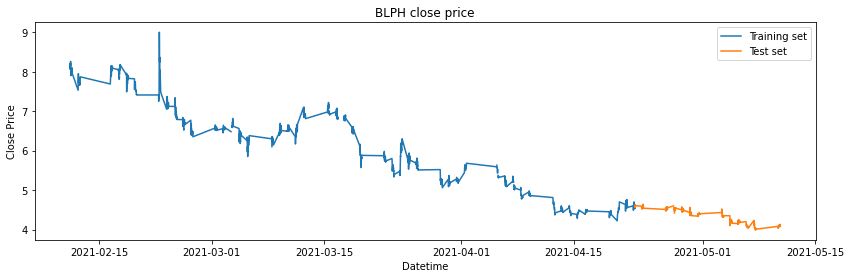

In [17]:
# testing the sets w/ matplotlib
plt.figure(figsize=(14,4))
plt.plot(training_data.close_price['BLPH'])
plt.plot(test_data.close_price['BLPH'])
plt.ylabel('Close Price')
plt.xlabel('Datetime')
plt.legend(["Training set", "Test set"])
plt.title("BLPH close price")
plt.show()

## Data Normalization
This method uses the MinMaxScaler, but a log return can sometimes be more useful. 

In [18]:
# I have altered this so it works better w/ my data.
minmax = MinMaxScaler(feature_range=(0,1))
minmax_single = MinMaxScaler(feature_range=(0,1))

# no idea if the line below will work the way I need it to or not
train_scaled = np.concatenate([minmax.fit_transform(training_data.close_price.values)], axis=1)

train_scaled = pd.DataFrame(train_scaled, columns=training_data.columns)
train_scaled

close_price                                                    \
stock_symbol        AACG     AAGFF      AAIC      AAME       AAU      ABEO   
0               0.966820  0.805851  0.102667  0.669698  0.851893  0.922018   
1               0.930755  0.761674  0.120000  0.691503  0.881960  0.891881   
2               0.896993  0.767487  0.120000  0.675928  0.874538  0.880734   
3               0.902208  0.789576  0.118667  0.685273  0.904974  0.902798   
4               0.878738  0.806433  0.100000  0.672813  1.000000  0.894771   
...                  ...       ...       ...       ...       ...       ...   
1263            0.013150  0.108700  0.493333  0.221156  0.213808  0.155963   
1264            0.006936  0.102306  0.480000  0.211812  0.211024  0.144495   
1265            0.001387  0.088743  0.460000  0.208697  0.208797  0.144495   
1266            0.000000  0.072660  0.453333  0.205582  0.200260  0.146789   
1267            0.005992  0.070529  0.453333  0.211812  0.198589  0.149083   

                                                      ...                      \
stock_symbol     ABEPF      ABEV      ABIO      ABML  ...      YTRA       YVR   
0             0.964842  0.841151  0.997900  0.898661  ...       NaN       NaN   
1             0.897513  0.794431  0.995434  0.889813  ...       NaN       NaN   
2             0.954984  0.803775  0.958904  0.873118  ...       NaN       NaN   
3             0.836057  0.787143  0.968036  0.876457  ...       NaN       NaN   
4             0.891850  0.785087  0.986804  0.874620  ...       NaN       NaN   
...                ...       ...       ...       ...  ...       ...       ...   
1263               NaN  0.943936  0.123288  0.195299  ...  0.169886  0.219454   
1264               NaN  0.943936  0.114155  0.191960  ...  0.113636  0.203560   
1265          0.018814  0.971968  0.086758  0.171926  ...  0.125000  0.199852   
1266          0.000420  0.971968  0.105023  0.173261  ...  0.068182  0.208858   
1267          0.008579  0.990656  0.109589  0.191960  ...  0.079545  0.206915   

                                                                          \
stock_symbol      ZCMD      ZIOP      ZKIN      ZNOG       ZOM      ZSAN   
0                  NaN       NaN       NaN       NaN       NaN       NaN   
1                  NaN       NaN       NaN       NaN       NaN       NaN   
2                  NaN       NaN       NaN       NaN       NaN       NaN   
3                  NaN       NaN       NaN       NaN       NaN       NaN   
4                  NaN       NaN       NaN       NaN       NaN       NaN   
...                ...       ...       ...       ...       ...       ...   
1263          0.121795  0.113636  0.136461  0.047155  0.103054  0.101761   
1264          0.128205  0.097107  0.135394  0.013550  0.075470  0.104410   
1265               NaN  0.095041  0.121535  0.000271  0.070484  0.083608   
1266               NaN  0.107438  0.117271  0.000000  0.085934  0.094009   
1267               NaN  0.111570  0.116205  0.013415  0.086811  0.100410   

                                  
stock_symbol       ZVO      ZYNE  
0                  NaN       NaN  
1                  NaN       NaN  
2                  NaN       NaN  
3                  NaN       NaN  
4                  NaN       NaN  
...                ...       ...  
1263          0.092699  0.224702  
1264          0.058990  0.197582  
1265          0.081463  0.191384  
1266          0.075845  0.187897  
1267          0.070227  0.203394  

[1268 rows x 1095 columns]

In [19]:
# validate min/max values
train_scaled.describe()

close_price                                                      \
stock_symbol         AACG        AAGFF         AAIC         AAME          AAU   
count         1240.000000  1194.000000  1264.000000  1214.000000  1268.000000   
mean             0.480155     0.422660     0.530682     0.323448     0.336352   
std              0.232120     0.251439     0.169203     0.197150     0.248490   
min              0.000000     0.000000     0.000000     0.000000     0.000000   
25%              0.353715     0.244332     0.446666     0.165088     0.145648   
50%              0.473007     0.364561     0.506667     0.255404     0.271994   
75%              0.633891     0.585458     0.586667     0.429464     0.515822   
max              1.000000     1.000000     1.000000     1.000000     1.000000   

                                                                               \
stock_symbol         ABEO        ABEPF         ABEV         ABIO         ABML   
count         1268.000000  1099.000000  1268.000000  1268.000000  1268.000000   
mean             0.321583     0.205592     0.622755     0.369689     0.358104   
std              0.192929     0.183512     0.187843     0.240396     0.250114   
min              0.000000     0.000000     0.000000     0.000000     0.000000   
25%              0.187030     0.097931     0.523454     0.165548     0.170256   
50%              0.325688     0.154794     0.635582     0.365297     0.287956   
75%              0.435780     0.244713     0.747711     0.506849     0.510000   
max              1.000000     1.000000     1.000000     1.000000     1.000000   

              ...                                                      \
stock_symbol  ...         YTRA          YVR         ZCMD         ZIOP   
count         ...  1197.000000  1209.000000  1098.000000  1216.000000   
mean          ...     0.464170     0.214638     0.253191     0.416123   
std           ...     0.190598     0.168477     0.141810     0.282745   
min           ...     0.000000     0.000000     0.000000     0.000000   
25%           ...     0.329545     0.056987     0.153846     0.152893   
50%           ...     0.443182     0.185600     0.240064     0.389463   
75%           ...     0.568182     0.357215     0.304199     0.690083   
max           ...     1.000000     1.000000     1.000000     1.000000   

                                                                               \
stock_symbol         ZKIN         ZNOG          ZOM         ZSAN          ZVO   
count         1216.000000  1208.000000  1216.000000  1216.000000  1213.000000   
mean             0.373967     0.501962     0.521724     0.463238     0.379458   
std              0.215677     0.203098     0.261932     0.177709     0.240530   
min              0.000000     0.000000     0.000000     0.000000     0.000000   
25%              0.187569     0.279709     0.304863     0.360036     0.109554   
50%              0.346573     0.562331     0.586906     0.464947     0.415742   
75%              0.521130     0.623306     0.737625     0.572682     0.581477   
max              1.000000     1.000000     1.000000     1.000000     1.000000   

                           
stock_symbol         ZYNE  
count         1216.000000  
mean             0.412374  
std              0.196932  
min              0.000000  
25%              0.268741  
50%              0.402952  
75%              0.501220  
max              1.000000  

[8 rows x 1095 columns]

## Shaping data for LSTM

In [20]:
train_scaled = train_scaled.values
n_lags = int(60) # not sure why hard 60
X_train = []
y_train = []
for i in range(n_lags, train_scaled.shape[0]):
    X_train.append(train_scaled[i-n_lags:i])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], -1))

# check shape (again) before start training
'''shape_chk = []
for i in train_scaled.close_price.columns:
    index = {}
    index["X_train"] = X_train.shape
    index["y_train"] = y_train.shape
    shape_chk.append(index)
pd.DataFrame(shape_chk)'''

'shape_chk = []\nfor i in train_scaled.close_price.columns:\n    index = {}\n    index["X_train"] = X_train.shape\n    index["y_train"] = y_train.shape\n    shape_chk.append(index)\npd.DataFrame(shape_chk)'

In [21]:
X_train.shape, y_train.shape

((1208, 60, 1095), (1208,))

## Build the LSTM network

In [27]:
%time

# LSTM architecture
regressor = tf.keras.Sequential()

# Layer 1, w/ dropout regularisation
regressor.add(tf.keras.layers.LSTM(units=20, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
regressor.add(tf.keras.layers.Dropout(0.3))

# Layer 2
regressor.add(tf.keras.layers.LSTM(units=20, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.3))

# Layer 3
regressor.add(tf.keras.layers.LSTM(units=20, return_sequences=True))
regressor.add(tf.keras.layers.Dropout(0.6))

# Layer 4
regressor.add(tf.keras.layers.LSTM(units=20))
regressor.add(tf.keras.layers.Dropout(0.6))

# Output layer
regressor.add(tf.keras.layers.Dense(units=1))

# Compile LSTM
regressor.compile(optimizer='adam', loss='mean_squared_error')

# fit to training set
'''for i in training_data.close_price.columns:
    print("Fitting to", i)'''
regressor.fit(X_train, y_train, epochs=10, batch_size=128)

Wall time: 0 ns
Fitting to AACG
Fitting to AAGFF
Fitting to AAIC
Fitting to AAME
Fitting to AAU
Fitting to ABEO
Fitting to ABEPF
Fitting to ABEV
Fitting to ABIO
Fitting to ABML
Fitting to ABQQ
Fitting to ABUS
Fitting to ACER
Fitting to ACRHF
Fitting to ACRX
Fitting to ACST
Fitting to ACTG
Fitting to ADIL
Fitting to ADMA
Fitting to ADMP
Fitting to ADMS
Fitting to ADOM
Fitting to ADTX
Fitting to ADXS
Fitting to AEG
Fitting to AEHL
Fitting to AEHR
Fitting to AEMD
Fitting to AESE
Fitting to AEY
Fitting to AEZS
Fitting to AFI
Fitting to AGE
Fitting to AGEN
Fitting to AGFS
Fitting to AGRX
Fitting to AGTC
Fitting to AHC
Fitting to AHPI
Fitting to AHT
Fitting to AIHS
Fitting to AIKI
Fitting to AIM
Fitting to AIRI
Fitting to AKBA
Fitting to AKER
Fitting to AKTX
Fitting to AKU
Fitting to ALEAF
Fitting to ALIM
Fitting to ALJJ
Fitting to ALNA
Fitting to ALPP
Fitting to ALRN
Fitting to ALSK
Fitting to ALTD
Fitting to ALYA
Fitting to AMBO
Fitting to AMC
Fitting to AMMJ
Fitting to AMPE
Fitting to AMP